In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/data7/brandon/research/DA_MVR/sil_consistent_at_inference')
import sys

import torch
from torch.nn import functional as F
from PIL import Image
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.transform import resize
from skimage import img_as_bool
from tqdm import tqdm
import glob
import pprint
import pickle
import copy
from pytorch3d.io import load_objs_as_meshes, load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftPhongShader
)

from utils import utils
from deformation.deformation_net import DeformationNetwork
from mesh_refiner import MeshRefiner
import deformation.losses

In [3]:
DATASET_PATH = "notebooks/test_dataset"
mesh_paths = sorted(glob.glob(os.path.join(DATASET_PATH, "*mesh.obj")))
data_info = []
pred_poses = pickle.load(open("notebooks/test_dataset_cached_pred_poses.p", "rb"))
# todo: add back in last one by adding in cache
for mesh_path in mesh_paths:
    instance_number = int(mesh_path.split('/')[-1][:2])
    instance_img_path = os.path.join(DATASET_PATH, "{:02d}_in.jpg".format(instance_number))
    instance_mask_path = os.path.join(DATASET_PATH, "00{:02d}.png".format(instance_number+1))
    img_name = instance_img_path.split('/')[-1]
    simp_mesh_path = mesh_path.replace(".obj","_simp.obj")
    data_info.append({"mesh": mesh_path, "simp_mesh": simp_mesh_path, "input_img": instance_img_path, "mask": instance_mask_path,
                      "azim": pred_poses[img_name]['azim'], "dist": pred_poses[img_name]['dist'], "elev": pred_poses[img_name]['elev']})

{'azim': 151.57894897460938,
 'dist': 1.269230842590332,
 'elev': 9.473684310913086,
 'input_img': 'notebooks/test_dataset/01_in.jpg',
 'mask': 'notebooks/test_dataset/0002.png',
 'mesh': 'notebooks/test_dataset/01_mesh.obj',
 'simp_mesh': 'notebooks/test_dataset/01_mesh_simp.obj'}
(224, 224, 3)
(224, 224)


/data7/drone_machinelearning/anaconda3/envs/standard/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


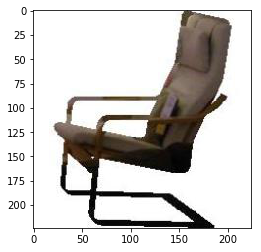

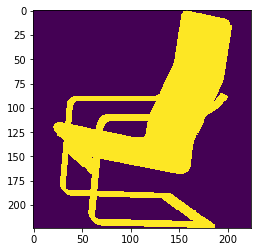

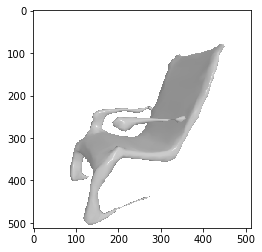

In [13]:
device = torch.device("cuda:7")

for data in data_info[1:2]:
    pprint.pprint(data)
    
    # loading in image, mesh, mask, predicted pose data
    input_image = np.asarray(Image.open(data['input_img']).convert('RGB'))
    with torch.no_grad():
        mesh = utils.load_untextured_mesh(data['simp_mesh'], device)
    mask = Image.open(data['mask']).resize((224,224))
    mask = np.asarray(mask)
    mask = (mask[:,:,3]> 0)
    pred_dist = data['dist']
    pred_elev = data['elev']
    pred_azim = data['azim']
    
    # rendering mesh at predicted pose
    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 
    mesh_rendered_at_pred_pose = utils.render_mesh(mesh, R, T, device)
    
    # visualizing
    print(input_image.shape)
    print(mask.shape)
    plt.imshow(input_image)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(mesh_rendered_at_pred_pose[0, ..., :3].cpu().numpy())
    plt.show()
    
    #break

In [155]:
cfg_yaml_path = "configs/default.yaml"
refiner = MeshRefiner(cfg_yaml_path, device)

refined_mesh, loss_info = refiner.refine_mesh(mesh, input_image, mask, pred_dist, pred_elev, pred_azim)

/data7/brandon/research/DA_MVR/sil_consistent_at_inference/utils/utils.py:50: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
100%|██████████| 700/700 [02:21<00:00,  4.93it/s]


1.269230842590332 9.473684310913086 151.57894897460938
torch.Size([1, 512, 512, 4])


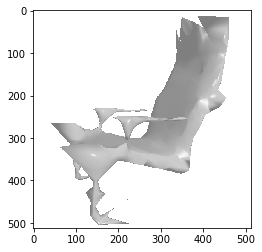

In [156]:
# rendering mesh at predicted pose
R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 

print(pred_dist, pred_elev, pred_azim)
refined_mesh_rendered = utils.render_mesh(refined_mesh, R, T, device)
print(refined_mesh_rendered.shape)

# visualizing
plt.imshow(refined_mesh_rendered[0, ..., :3].detach().cpu().numpy())

# saving mesh
save_obj("notebooks/refined_mesh.obj", refined_mesh.verts_packed(), refined_mesh.faces_packed())

In [131]:
display(loss_info)

,img_sym_loss,iter,l2_loss,lap_smoothness_loss,normal_consistency_loss,sil_loss,total_loss,vertex_sym_loss
0,0.025047,0.0,9.211041e-31,0.010694,0.077984,3.686595,40.571930,39.820530
1,0.025006,1.0,1.000489e-10,0.010693,0.077978,3.686540,40.498390,39.748222
2,0.024966,2.0,4.011374e-10,0.010692,0.077973,3.686526,40.424900,39.675934
3,0.024930,3.0,9.048605e-10,0.010691,0.077969,3.686164,40.351303,39.603397
4,0.024898,4.0,1.613812e-09,0.010690,0.077965,3.686161,40.273811,39.526882
...,...,...,...,...,...,...,...,...
695,0.004783,695.0,8.806779e-05,0.015458,0.446195,3.689455,0.835100,0.690725
696,0.004739,696.0,8.907023e-05,0.015500,0.515750,3.689783,0.836732,0.693672
697,0.004759,697.0,8.866394e-05,0.015478,0.478217,3.690118,0.803674,0.660005
698,0.004757,698.0,8.861824e-05,0.015472,0.466236,3.690020,0.793254,0.649645


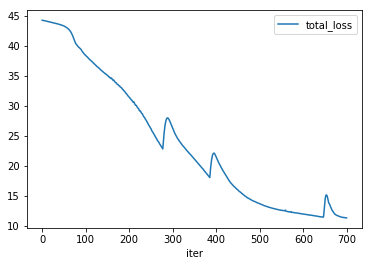

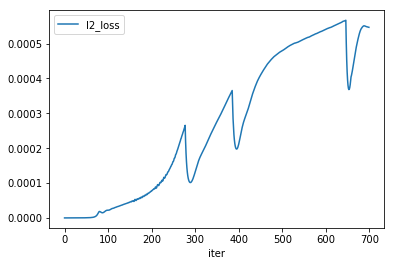

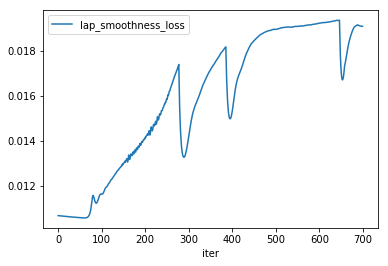

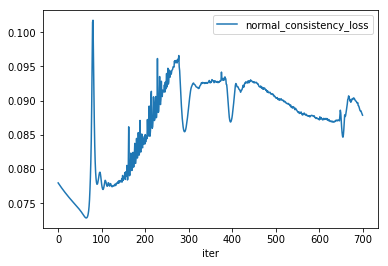

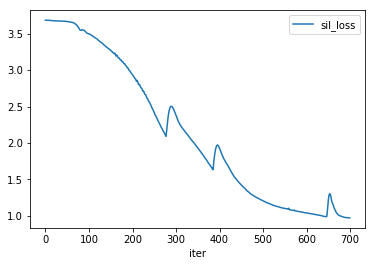

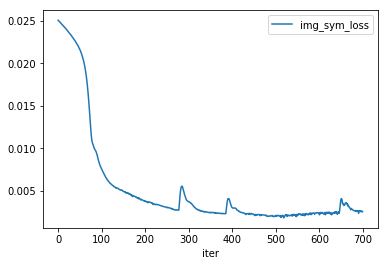

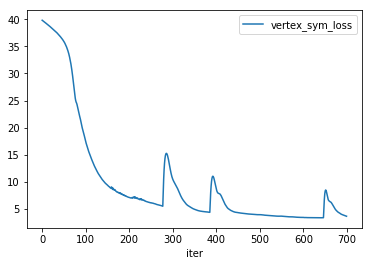

In [150]:
loss_info.plot.line(x='iter', y='total_loss')
loss_info.plot.line(x='iter', y='l2_loss')
loss_info.plot.line(x='iter', y='lap_smoothness_loss')
loss_info.plot.line(x='iter', y='normal_consistency_loss')
loss_info.plot.line(x='iter', y='sil_loss')
loss_info.plot.line(x='iter', y='img_sym_loss')
loss_info.plot.line(x='iter', y='vertex_sym_loss')

In [ ]:
# TODO: 
# experiment with small weights initalization
# try more fc layers in different configurations
# add smoothness losses from here:
# https://pytorch3d.readthedocs.io/en/latest/modules/loss.html
# add symmetry-based loss
# autoencoder embedding-space based formulation for realism loss

# loss based on distance to nearest neighbor

In [ ]:

print(deformation.losses.symmetry_loss(mesh, [0,0,1], device))
print("")
print(deformation.losses.symmetry_loss_fast(mesh, [0,0,1], device))

torch.Size([224, 224, 3])


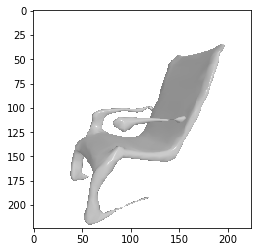

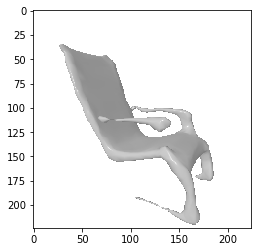

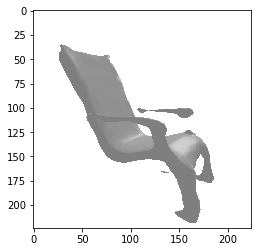

In [111]:
r1, r1_flipped, r2 = deformation.losses.image_symmetry_loss(mesh, [0,0,1], device)
plt.imshow(r1.detach().cpu().numpy())
plt.show()
plt.imshow(r1_flipped.detach().cpu().numpy())
plt.show()
plt.imshow(r2.detach().cpu().numpy())

In [127]:
deformation.losses.image_symmetry_loss(mesh, [0,0,1], device)

torch.Size([224, 224])


tensor(0.0250, device='cuda:7')

In [106]:
r1_flipped.shape

torch.Size([224, 224, 3])